<h2>1) ติดตั้งแพ็กเกจ</h2>
ติดตั้ง OpenCV (เวอร์ชันที่เสถียรกับ Colab), scikit-image (ใช้ SSIM/PSNR ได้), NumPy, Pandas


In [ ]:
%pip install "opencv-python==4.12.0.88" "scikit-image==0.25.2" "numpy==2.0.2" "pandas"

In [ ]:
import os, cv2, numpy as np, pandas as pd
from pathlib import Path
from skimage.metrics import structural_similarity as ssim
from math import log10

1.1) จัดเรียงไฟล์รูป เข้าโฟลดเดอร์อัตโนมัติ


In [21]:
from pathlib import Path
import shutil

DATA_DIR = Path("data")
imgs = sorted([p for p in DATA_DIR.iterdir() if p.suffix.lower() in [".jpg",".jpeg",".png"]])
for i, p in enumerate(imgs, start=1):
    sdir = DATA_DIR / f"set{i:02d}"
    sdir.mkdir(exist_ok=True)
    shutil.move(str(p), str(sdir/"input.jpg"))
print("จัดชุดเสร็จ ✅")


จัดชุดเสร็จ ✅


<h2>2) ตั้งค่าพาธและยูทิลิตี้พื้นฐาน</h2>

- data/set01/input.jpg … set10/input.jpg = dataset ที่คุณถ่ายเอง

- assets/reference.jpg = ภาพมุมตรง ใช้เปรียบเทียบผล (optional แต่แนะนำ)

- outputs/ = โฟลเดอร์เก็บภาพที่ warp แล้ว, ภาพ before/after, และตารางผลลัพธ์

In [ ]:
DATA_DIR = Path("data")           # โฟลเดอร์เก็บชุดภาพ set01..set10
REF_PATH = Path("assets/reference.jpg")  # ภาพอ้างอิง (ถ่ายตรง, optional)
OUT_DIR  = Path("outputs")        # โฟลเดอร์สำหรับเก็บผลลัพธ์
OUT_DIR.mkdir(exist_ok=True)      # สร้างโฟลเดอร์ outputs ถ้ายังไม่มี

<h2>3) Utils (ฟังก์ชันช่วยเหลือทั่วไป) </h2>
Utils (ฟังก์ชันช่วยเหลือทั่วไป)

In [ ]:
def imread_ok(p, flag=cv2.IMREAD_COLOR):
    img = cv2.imread(str(p), flag)
    if img is None: raise FileNotFoundError(p)
    return img

อ่านไฟล์ภาพ ถ้าไม่เจอจะ raise error แทนที่จะคืน None

In [ ]:
def to_gray(bgr):
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

แปลงภาพ BGR → grayscale

In [ ]:
def preprocess(gray):
    # 1) CLAHE เพิ่ม contrast
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    g = clahe.apply(gray)
    # 2) Gaussian blur ลด noise
    g = cv2.GaussianBlur(g, (5,5), 0)
    # 3) Adaptive threshold ทำภาพ binary
    th = cv2.adaptiveThreshold(g, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY, 31, 5)
    # 4) Morphology close เชื่อมเส้นขอบ
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel, iterations=1)
    return g, th

preprocessing ทำให้ edge/feature เด่นขึ้น เหมาะทั้ง contour และ ORB

In [ ]:
# จัดเรียง 4 จุด: top-left, top-right, bottom-right, bottom-left
def order_points(pts):
    rect = np.zeros((4,2), dtype="float32")
    s = pts.sum(axis=1); rect[0]=pts[np.argmin(s)]; rect[2]=pts[np.argmax(s)]
    diff = np.diff(pts, axis=1).ravel(); rect[1]=pts[np.argmin(diff)]; rect[3]=pts[np.argmax(diff)]
    return rect

In [ ]:
# รับ 4 จุด → คำนวณ Homography → warp ให้ตรงมุม
def four_point_warp(image, pts):
    # warp โดยใช้ขนาดตามด้านจริง (ไม่ fix size)
    rect = order_points(pts)
    (tl,tr,br,bl) = rect
    def dist(a,b): return np.linalg.norm(a-b)
    width  = int(max(dist(br,bl), dist(tr,tl)))
    height = int(max(dist(tr,br), dist(tl,bl)))
    width  = max(width,  100)  # กัน 0
    height = max(height, 140)
    dst = np.array([[0,0],[width-1,0],[width-1,height-1],[0,height-1]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (width, height))
    return warped, M

In [ ]:
# คำนวณค่า PSNR วัดความใกล้เคียงของภาพ a,b
def psnr(a,b):
    mse = np.mean((a.astype(np.float32)-b.astype(np.float32))**2)
    return 100.0 if mse==0 else 10*log10((255*255)/mse)

In [ ]:
# ต่อภาพ a,b ไว้ข้างกัน → ใช้แสดงเปรียบเทียบ before/after
def side_by_side(a,b, maxw=1600):
    h = min(a.shape[0], b.shape[0])
    ra = cv2.resize(a, (int(a.shape[1]*h/a.shape[0]), h))
    rb = cv2.resize(b, (int(b.shape[1]*h/b.shape[0]), h))
    cat = cv2.hconcat([ra, rb])
    if cat.shape[1] > maxw:
        s = maxw / cat.shape[1]; cat = cv2.resize(cat, (int(cat.shape[1]*s), int(cat.shape[0]*s)))
    return cat

<h2>4) Contour-based pipeline</h2>

In [ ]:
def detect_document_corners(img_bgr, use_preproc=False):
    gray = to_gray(img_bgr)
    if use_preproc:
        g, th = preprocess(gray)       # ใช้ CLAHE + blur + thresh
        edges = cv2.Canny(g, 50, 150)  # edge detection
    else:
        edges = cv2.Canny(gray, 50, 150)

    # หา contours
    cnts, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

    # เลือก contour ที่เป็นสี่เหลี่ยม 4 จุดใหญ่สุด
    best = None
    for c in cnts[:20]:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02*peri, True)
        if len(approx) == 4:
            area = cv2.contourArea(approx)
            if area > 0.05 * (img_bgr.shape[0]*img_bgr.shape[1]):
                best = approx.reshape(4,2).astype(np.float32)
                break
    return

<h2>5) ORB + RANSAC pipeline</h2>
ใช้ reference.jpg เป็นตัวจริง → เปรียบเทียบ input กับ reference ด้วย ORB features → คำนวณ Homography → warp ให้ตรง

In [ ]:
def orb_homography(input_bgr, ref_bgr, use_preproc=False, nfeat=6000, ratio=0.75, ransac_th=5.0):
    orb = cv2.ORB_create(nfeatures=nfeat)
    in_gray  = to_gray(input_bgr)
    ref_gray = to_gray(ref_bgr)
    if use_preproc:
        in_gray, _  = preprocess(in_gray)
        ref_gray, _ = preprocess(ref_gray)

    # ORB detect keypoints & descriptors
    k1, d1 = orb.detectAndCompute(in_gray, None)
    k2, d2 = orb.detectAndCompute(ref_gray, None)

    if d1 is None or d2 is None: return None, 0, 0, 0.0

    # Matching ด้วย BFMatcher + Lowe’s ratio
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    knn = bf.knnMatch(d1, d2, k=2)
    good = [m for m,n in knn if m.distance < ratio*n.distance]

    if len(good) < 4: return None, len(good), 0, 0.0

    # Homography + RANSAC
    src = np.float32([k1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst = np.float32([k2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
    H, mask = cv2.findHomography(src, dst, cv2.RANSAC, ransac_th)

    # inlier ratio = inliers/good matches
    inliers = int(mask.sum()) if (H is not None and mask is not None) else 0
    ratio_in = inliers / max(len(good),1)
    return H, len(good), inliers, ratio_in

<h2> 6) Batch run (ทำงานกับทั้ง 10 ชุด)

- สิ่งที่ run_batch() ทำ

- เปิดภาพแต่ละชุดใน data/setXX/input.jpg

- รันทั้ง Contour และ ORB (กรณีมี reference) โดยเปิด/ปิด preprocessing

- เซฟภาพ warp แล้วใน outputs/

- สร้าง results.csv สรุปค่า metrics ของทุกชุด

In [ ]:
# ====== Batch run ======
def run_batch():
    rows = []
    ref_img = imread_ok(REF_PATH) if REF_PATH.exists() else None

    (OUT_DIR/"contour_raw").mkdir(parents=True, exist_ok=True)
    (OUT_DIR/"contour_pre").mkdir(parents=True, exist_ok=True)
    (OUT_DIR/"orb_raw").mkdir(parents=True, exist_ok=True)
    (OUT_DIR/"orb_pre").mkdir(parents=True, exist_ok=True)
    (OUT_DIR/"visuals").mkdir(parents=True, exist_ok=True)

    sets = sorted([p for p in DATA_DIR.glob("set*") if p.is_dir()])
    assert len(sets) >= 10, "ต้องมีอย่างน้อย 10 ชุด (set01..set10)"
    for s in sets:
        inp = s/"input.jpg"
        if not inp.exists():
            print("Skip (no input):", s);
            continue
        img = imread_ok(inp)

        # A) Contour-based: raw & preproc
        for pre in [False, True]:
            pts = detect_document_corners(img, use_preproc=pre)
            psnr_v = ssim_v = None
            if pts is not None:
                warped, M = four_point_warp(img, pts)
                outp = OUT_DIR/("contour_pre" if pre else "contour_raw")/(s.name+".jpg")
                cv2.imwrite(str(outp), warped)
                if ref_img is not None:
                    ref_rs = cv2.resize(ref_img, (warped.shape[1], warped.shape[0]))
                    psnr_v = psnr(warped, ref_rs)
                    ssim_v = ssim(cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY),
                                  cv2.cvtColor(ref_rs, cv2.COLOR_BGR2GRAY))
                vis = side_by_side(img, warped)
                cv2.imwrite(str(OUT_DIR/"visuals"/f"{s.name}_contour_{'pre' if pre else 'raw'}.jpg"), vis)
            rows.append({"set": s.name, "method":"contour", "preproc": pre,
                         "good_matches": None, "inliers": None, "inlier_ratio": None,
                         "PSNR": psnr_v, "SSIM": ssim_v})

        # B) ORB + RANSAC (ต้องมี reference)
        if ref_img is not None:
            for pre in [False, True]:
                H, good, inl, ratio_in = orb_homography(img, ref_img, use_preproc=pre)
                psnr_v = ssim_v = None
                if H is not None:
                    h,w = ref_img.shape[:2]
                    warped = cv2.warpPerspective(img, H, (w,h))
                    cv2.imwrite(str(OUT_DIR/("orb_pre" if pre else "orb_raw")/(s.name+".jpg")), warped)
                    psnr_v = psnr(warped, ref_img)
                    ssim_v = ssim(cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY),
                                  cv2.cvtColor(ref_img, cv2.COLOR_BGR2GRAY))
                    vis = side_by_side(img, warped)
                    cv2.imwrite(str(OUT_DIR/"visuals"/f"{s.name}_orb_{'pre' if pre else 'raw'}.jpg"), vis)
                rows.append({"set": s.name, "method":"orb", "preproc": pre,
                             "good_matches": good, "inliers": inl, "inlier_ratio": ratio_in,
                             "PSNR": psnr_v, "SSIM": ssim_v})
    df = pd.DataFrame(rows).sort_values(["set","method","preproc"]).reset_index(drop=True)
    df.to_csv(OUT_DIR/"results.csv", index=False)
    print(df)
    return df

if __name__ == "__main__":
    run_batch()

      set   method  preproc good_matches inliers inlier_ratio  PSNR  SSIM
0   set01  contour    False         None    None         None  None  None
1   set01  contour     True         None    None         None  None  None
2   set02  contour    False         None    None         None  None  None
3   set02  contour     True         None    None         None  None  None
4   set03  contour    False         None    None         None  None  None
5   set03  contour     True         None    None         None  None  None
6   set04  contour    False         None    None         None  None  None
7   set04  contour     True         None    None         None  None  None
8   set05  contour    False         None    None         None  None  None
9   set05  contour     True         None    None         None  None  None
10  set06  contour    False         None    None         None  None  None
11  set06  contour     True         None    None         None  None  None
12  set07  contour    False         No

<h2> 7) แสดงผลลัพธ์ต่างๆ


In [22]:
import pandas as pd
from IPython.display import display
df = pd.read_csv("outputs/results.csv")
display(df.head(20))   # แสดงแถวต้น ๆ

,set,method,preproc,good_matches,inliers,inlier_ratio,PSNR,SSIM
0,set01,contour,False,NaN,NaN,NaN,NaN,NaN
1,set01,contour,True,NaN,NaN,NaN,NaN,NaN
2,set01,orb,False,2103.0,1987.0,0.944841,18.445758,0.679155
3,set01,orb,True,1727.0,1622.0,0.939201,18.442027,0.679932
4,set02,contour,False,NaN,NaN,NaN,NaN,NaN
5,set02,contour,True,NaN,NaN,NaN,NaN,NaN
6,set02,orb,False,1532.0,1383.0,0.902742,19.455832,0.678150
7,set02,orb,True,1338.0,1184.0,0.884903,18.686616,0.648161
8,set03,contour,False,NaN,NaN,NaN,NaN,NaN
9,set03,contour,True,NaN,NaN,NaN,NaN,NaN


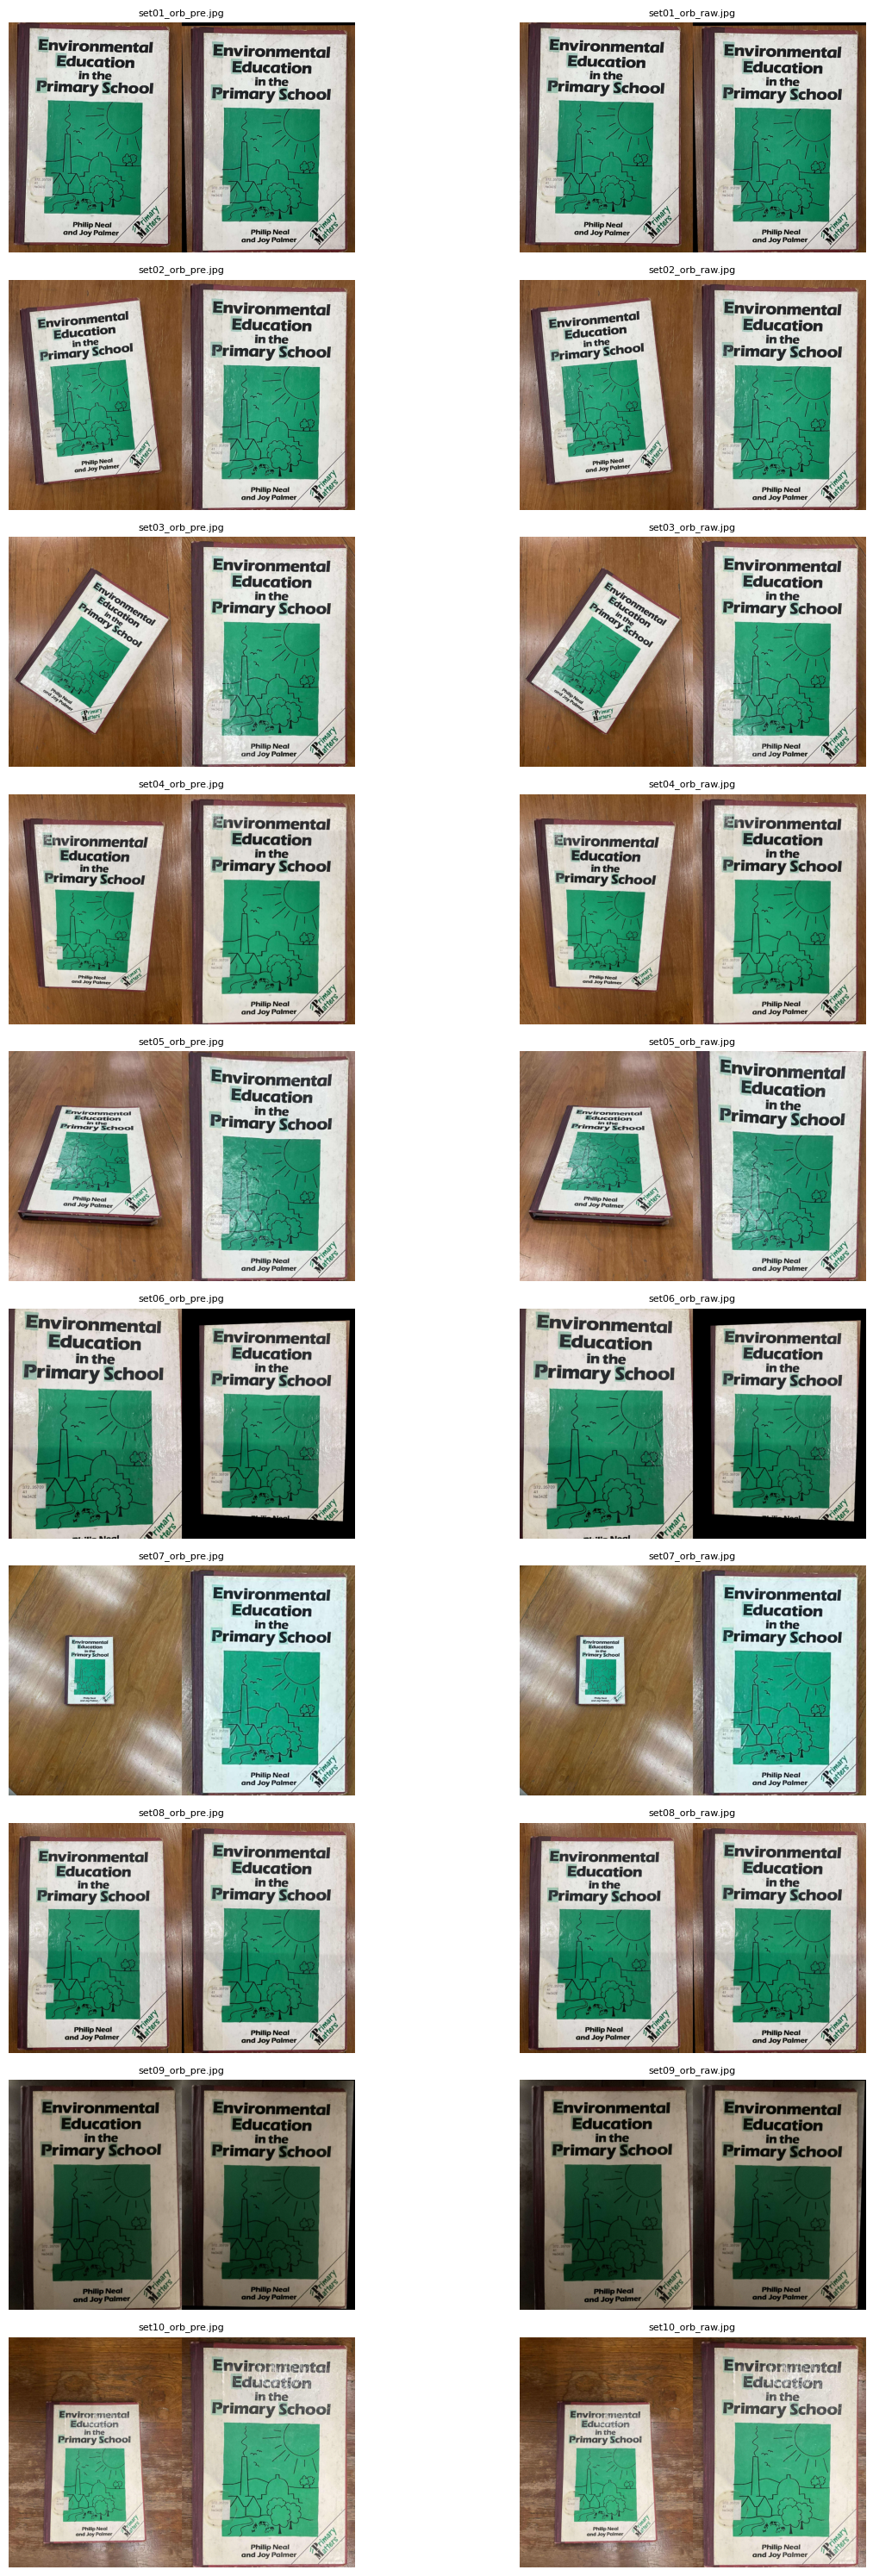

In [25]:
import matplotlib.pyplot as plt
import cv2, glob, math
from pathlib import Path

# โฟลเดอร์เก็บภาพ
VISUALS_DIR = Path("outputs/visuals")

# หาไฟล์ทั้งหมดที่ลงท้ายด้วย .jpg (หรือ .png)
paths = sorted(glob.glob(str(VISUALS_DIR / "*.jpg")))

if len(paths) == 0:
    print("❗ ไม่พบภาพใน outputs/visuals/")
else:
    cols = 2  # จำนวนภาพต่อแถว
    rows = math.ceil(len(paths)/cols)

    plt.figure(figsize=(14, 3*rows))
    for i, p in enumerate(paths, 1):
        img = cv2.imread(p)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(Path(p).name, fontsize=8)
    plt.tight_layout()
    plt.show()
